In [2]:
from pathlib import Path
from one.api import ONE
from prior_localization.functions.decoding import fit_session_ephys
import tempfile

# Instantiate ONE to connect to the public IBL database
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international')

# UUID of an example session
session_id = '56956777-dca5-468c-87cb-78150432cc57'

# Get some other required information through the ONE API, like subject nickname and probe names
subject = one.eid2ref(session_id)['subject']
probe_names = one.eid2pid(session_id)[1]

# Create a temporary directory for the outputs (you can replace this with permanent path on your disk)
output_dir = Path(tempfile.TemporaryDirectory().name)

In [3]:
# For this session, we decode the Bayes Optimal prior from the neural activity. More specifically, we identify
# the regions along the probe(s) probe_names, and perform a region-level decoding (as defined by the
# "regions" argument).
# For each region, we decode from all units the variable "target" (pLeft here - so the prior that the
# stimulus will appear on the left side) from the model "model" (optimal Bayesian here) using Lasso linear
# regression (see Methods of the paper for more information).
# Pseudo_ids gives the information of whether we decode the session's Bayes optimal prior
# (pseudo_id=-1) or whether we decode a counterfactual Bayes optimal prior, from an unobserved pseudo-session
# (pseudo_id > 0). pseudo_ids=[-1, 1, 2] indicates that we decode the session's prior as well as
# counterfactual prior from 2 pseudo-sessions (in the paper, we actually decode priors from 200
# pseudo-sessions).
# Neural activity is defined as the sum of the spikes over a time window (corresponding to the "time_window"
# argument, here -600 to # -100ms) aligned to a particular event (defined by the "stimOn_times" argument,
# here stimulus onset)
results_fit_session = fit_session_ephys(
    one, session_id, subject, probe_names, model='optBay', pseudo_ids=[-1, 1, 2], target='pLeft',
    align_event='stimOn_times', time_window=(-0.6, -0.1), output_dir=output_dir, regions='single_regions'
)

CA1 below min units threshold (10) : 6, not decoding
CA3 below min units threshold (10) : 5, not decoding
COAp below min units threshold (10) : 8, not decoding
IA below min units threshold (10) : 9, not decoding
PA below min units threshold (10) : 4, not decoding
SSp-bfd below min units threshold (10) : 1, not decoding
SSp-tr below min units threshold (10) : 3, not decoding
VISa below min units threshold (10) : 1, not decoding


In [4]:
# The function outputs, for each region and for each pseudo_id, the path file of the decoding results.
results_fit_session

[PosixPath('/var/folders/1t/8t6nbf0x4sb1zn7t040fz2380000gn/T/tmpzl4cbhxv/neural/30-01-2023/ephys/NYU-11/56956777-dca5-468c-87cb-78150432cc57/merged_probes/BMA_target_pLeft_timeWindow_-0_6_-0_1_pseudo_id_-1_2_balanced_weighting_True.pkl'),
 PosixPath('/var/folders/1t/8t6nbf0x4sb1zn7t040fz2380000gn/T/tmpzl4cbhxv/neural/30-01-2023/ephys/NYU-11/56956777-dca5-468c-87cb-78150432cc57/merged_probes/CEA_target_pLeft_timeWindow_-0_6_-0_1_pseudo_id_-1_2_balanced_weighting_True.pkl'),
 PosixPath('/var/folders/1t/8t6nbf0x4sb1zn7t040fz2380000gn/T/tmpzl4cbhxv/neural/30-01-2023/ephys/NYU-11/56956777-dca5-468c-87cb-78150432cc57/merged_probes/GPe_target_pLeft_timeWindow_-0_6_-0_1_pseudo_id_-1_2_balanced_weighting_True.pkl'),
 PosixPath('/var/folders/1t/8t6nbf0x4sb1zn7t040fz2380000gn/T/tmpzl4cbhxv/neural/30-01-2023/ephys/NYU-11/56956777-dca5-468c-87cb-78150432cc57/merged_probes/LGd_target_pLeft_timeWindow_-0_6_-0_1_pseudo_id_-1_2_balanced_weighting_True.pkl'),
 PosixPath('/var/folders/1t/8t6nbf0x4sb1zn7t

In [5]:
# loading results of first saved result
import pickle
import numpy as np
path_to_decoding_results = results_fit_session[0]
decoding_results = pickle.load(open(path_to_decoding_results, 'rb'))

In [6]:
# decoding results have keys describing metadata and the decoding results present under the key "fit"
print(f'decoding keys are {decoding_results.keys()}')
print(f'decoding session: {decoding_results["eid"]}, \n'
      f'decoding subject: {decoding_results["subject"]} \n'
      f'decoding region: {decoding_results["region"]} \n'
      f'number of units in region: {decoding_results["N_units"]}')

decoding keys are dict_keys(['fit', 'subject', 'eid', 'probe', 'region', 'N_units'])
decoding session: 56956777-dca5-468c-87cb-78150432cc57, 
decoding subject: NYU-11 
decoding region: ['BMA'] 
number of units in region: 51


In [11]:
# decoding results have keys describing metadata and the decoding results present under the key "fit"
# one decoding for each pseudo_id has been performed
print(f"number of decodings performed: {len(decoding_results['fit'])}")

number of decodings performed: 3


In [18]:
# let's iterate over the results and save the predicted prior when the session's BayesOpt prior
# was decoded (pseudo_id = -1)
for fit in decoding_results['fit']:
    if fit['pseudo_id'] == -1:
        predictions = np.vstack(fit['predictions_test']).squeeze()
        target = np.vstack(fit['target']).squeeze()

Text(0, 0.5, 'pLeft')

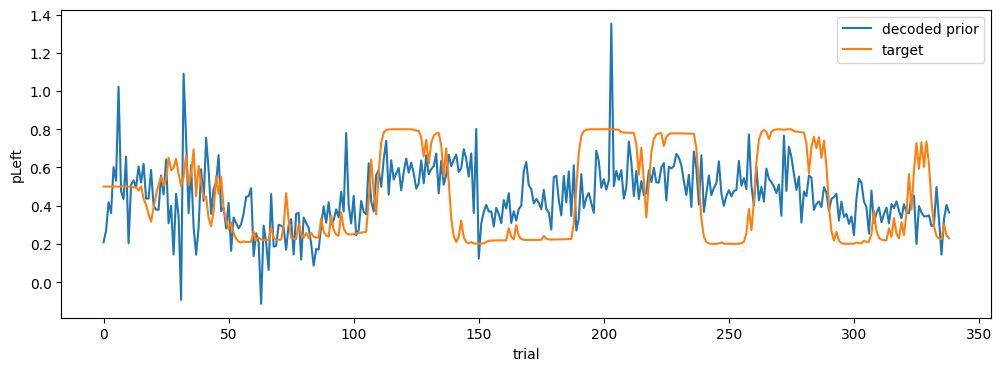

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,4))
plt.plot(predictions, label='decoded prior')
plt.plot(target, label='target')
plt.legend()
plt.xlabel('trial')
plt.ylabel('pLeft')

In [44]:
# additionally we can compute the Rsquared.
# pseudo_Rsquared are the Rsquared when decoding the counterfactual BayesOpt prior from unobserved pseudosessions
pseudo_Rsquared = []
for fit in decoding_results['fit']:
    if fit['pseudo_id'] == -1:
        Rsquared = fit['scores_test_full']
    else:
        pseudo_Rsquared.append(fit['scores_test_full'])
# to obtain the "corrected RSquared" that accounts for spurious correlations, we substract the pseudosessions
# Rsquareds for the sessions Rsquared
print(f'Uncorrected session Rsquared: {Rsquared}')
print(f'Average pseudosession Rsquared: {np.mean(pseudo_Rsquared)}')
print(f'Corrected Rsquared: {Rsquared - np.mean(pseudo_Rsquared)}')

Uncorrected session Rsquared: 0.061786957193274095
Average pseudosession Rsquared: 0.17914114982128854
Corrected Rsquared: -0.11735419262801444
